In [2]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import librosa
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [3]:
from keras.models import Model
from keras.layers import Input, Dense, Softmax, Dropout, BatchNormalization, Activation

from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

import keras

# Preprocessing

From generated chords, get the following:

- Chord name (A, B, C, D...)
- Chord type (major, minor, dimishished, diminished 7, etc.)
- instrument type

In [13]:
chord_filenames = glob("../../data/nsynth-train/generated_chords/*.wav")

In [14]:
len(chord_filenames)

240056

In [24]:
chord_filenames[0]

'../../data/nsynth-train/generated_chords/G#5_min7_string_acoustic_067_iter2.wav'

In [26]:
from collections import namedtuple
def get_chord_metadata_from_filename(filename):
    filename = filename.split("/")[-1]
    metadata_data = filename.split("_")
    meta = namedtuple("metadata", "chord_name chord_name_base chord_type instrument_family instrument_source instrument_key")
    out = meta(chord_name=metadata_data[0],
               chord_name_base=''.join([i for i in metadata_data[0] if not i.isdigit()]),
               chord_type=metadata_data[1],
               instrument_family=metadata_data[2],
               instrument_source=metadata_data[3],
               instrument_key="_".join(metadata_data[2:5]))
    
    return out

In [27]:
# Get metadata from each filename
metadata = [get_chord_metadata_from_filename(file) for file in tqdm(chord_filenames)]

In [28]:
metadata_df = pd.DataFrame.from_records(metadata)
metadata_df.columns = ["chord_name", "chord_name_base", "chord_type", "instrument_family", "instrument_source", "instrument_key"]
metadata_df['filename'] = chord_filenames

In [30]:
# Get counts of each of our classes
metadata_df.chord_name_base.value_counts()

D     28111
B     26900
F#    23046
A     21666
E     21129
G     20723
G#    20290
C#    19654
D#    19107
C     18126
F     13058
A#     8246
Name: chord_name_base, dtype: int64

In [105]:
metadata_df.instrument_family.value_counts()

string      112705
guitar       73553
keyboard     52688
bass          1110
Name: instrument_family, dtype: int64

# Modeling

For a first pass (faster), sample ~100000 chords and see if we can get a model to learn anything

NOTE: We need to ensure that the testing set contains new/distinct instruments that are not in the training set.  We cannot simply do metadata_df.sample(n).  We must sample n instruments from the dataset and ensure there are distinct instruments between train/test

In [33]:
unique_instrument_keys = metadata_df.instrument_key.unique()

In [40]:
unique_instrument_keys.shape[0]*.80

110.4

In [106]:
# 70% of instruments in training
# 15% of instruments in validation
# 15% of instruments in testing
train_instrument_keys = np.random.choice(unique_instrument_keys, int(unique_instrument_keys.shape[0]*.80))
remaining = unique_instrument_keys[np.where(~np.isin(unique_instrument_keys, train_instrument_keys))]
val_instrument_keys = np.random.choice(remaining, int(remaining.shape[0]*.5))
test_instrument_keys = remaining[np.where(~np.isin(remaining, val_instrument_keys))]

In [107]:
metadata_df[metadata_df.instrument_key.isin(val_instrument_keys)].instrument_family.unique()

array(['string', 'guitar', 'keyboard'], dtype=object)

In [108]:
metadata_df[metadata_df.instrument_key.isin(test_instrument_keys)].instrument_family.unique()

array(['string', 'guitar', 'keyboard'], dtype=object)

In [109]:
train_df_sample = metadata_df[metadata_df.instrument_key.isin(train_instrument_keys)]
val_df_sample = metadata_df[metadata_df.instrument_key.isin(val_instruement_keys)]
test_df_sample = metadata_df[metadata_df.instrument_key.isin(test_instrument_keys)]

In [110]:
# Import .wav files
train_x_input = [librosa.load(file, sr=16000, duration=1)[0] for file in tqdm(train_df_sample.filename)]

In [111]:
val_x_input = [librosa.load(file, sr=16000, duration=1)[0] for file in tqdm(val_df_sample.filename)]

In [112]:
test_x_input = [librosa.load(file, sr=16000, duration=1)[0] for file in tqdm(test_df_sample.filename)]

In [113]:
import scipy.fftpack

In [114]:
# Convert all chords from time to frequency domain
train_x_fft = [scipy.fftpack.fft(sound)[0:8000] for sound in tqdm(train_x_input)]
train_x_fft = np.array(train_x_fft)

In [115]:
val_x_fft = [scipy.fftpack.fft(sound)[0:8000] for sound in tqdm(val_x_input)]
val_x_fft = np.array(val_x_fft)

In [116]:
test_x_fft = [scipy.fftpack.fft(sound)[0:8000] for sound in tqdm(test_x_input)]
test_x_fft = np.array(test_x_fft)

In [117]:
del(train_x_input)
del(val_x_input)
del(test_x_input)

In [118]:
# Create one hot matrix of instrument type
le_note_base = LabelEncoder()
le_note_base.fit(train_df_sample.chord_name_base)
train_y_note_base = to_categorical(le_note_base.transform(train_df_sample.chord_name_base))
val_y_note_base = to_categorical(le_note_base.transform(val_df_sample.chord_name_base))
test_y_note_base = to_categorical(le_note_base.transform(test_df_sample.chord_name_base))

le_instrument_family = LabelEncoder()
le_instrument_family.fit(train_df_sample.instrument_family)
train_y_instrument_family = to_categorical(le_instrument_family.transform(train_df_sample.instrument_family))
val_y_instrument_family = to_categorical(le_instrument_family.transform(val_df_sample.instrument_family))
test_y_instrument_family = to_categorical(le_instrument_family.transform(test_df_sample.instrument_family))

le_chord_type = LabelEncoder()
le_chord_type.fit(train_df_sample.chord_type)
train_y_chord_type = to_categorical(le_chord_type.transform(train_df_sample.chord_type))
val_y_chord_type = to_categorical(le_chord_type.transform(val_df_sample.chord_type))
test_y_chord_type = to_categorical(le_chord_type.transform(test_df_sample.chord_type))

## Chord Classification

In [119]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
# lay1 = Dropout(.2)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
# lay2 = Dropout(.2)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.2)(lay3)

output = Dense(12, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 8000)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                400050    
_________________________________________________________________
batch_normalization_25 (Batc (None, 50)                200       
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_26 (Batc (None, 50)                200       
_________________________________________________________________
dense_35 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_27 (Batc (None, 50)                200       
__________

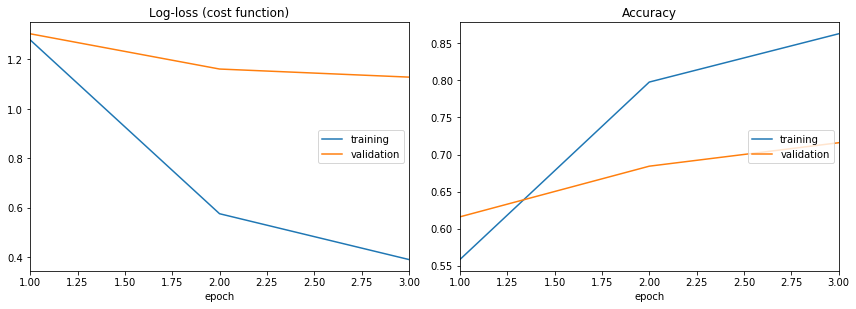

In [121]:
history = model.fit([train_x_fft],
                    train_y_note_base,
                    epochs=3,
                    batch_size=32,
                    validation_data=(val_x_fft, val_y_note_base),
                    callbacks=[PlotLossesKeras()])

In [122]:
# Test set predictions
model.evaluate(test_x_fft, test_y_note_base)

  384/54476 [..............................] - ETA: 26s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


54476/54476 [==============================] - 31s 562us/step


[2.315313595280842, 0.4778250972883617]

## Instrument type classification

In [123]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
# lay1 = Dropout(.2)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
# lay2 = Dropout(.2)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.2)(lay3)

output = Dense(4, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

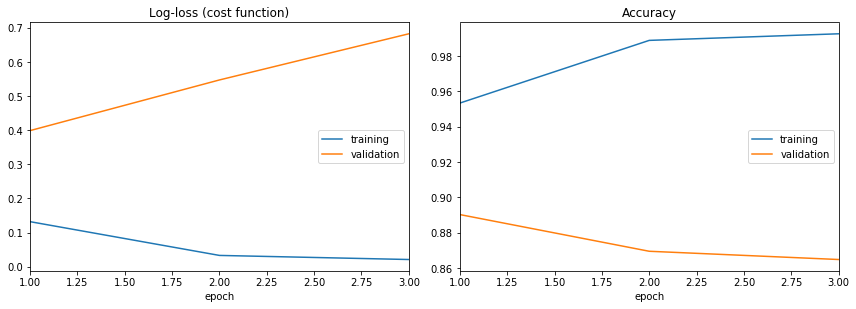

In [124]:
history = model.fit([train_x_fft],
                    train_y_instrument_family,
                    epochs=3,
                    batch_size=32,
                    validation_data=(val_x_fft, val_y_instrument_family),
                    callbacks=[PlotLossesKeras()])

In [125]:
model.evaluate(test_x_fft, test_y_instrument_family)

  544/54476 [..............................] - ETA: 17s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


54476/54476 [==============================] - 27s 493us/step


[3.143201933049606, 0.53054556134374]

We can predict our 4 initial instrument families (guitar, piano, strings, bass) with ~99% accuracy.  This instruments are fairly distinct from one another.  Would we expect our accuracy to decrease as we introduce more obscure instrument families into the dataset?

## Chord Type

In [126]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
lay1 = Dropout(.5)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
lay2 = Dropout(.5)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
lay3 = Dropout(.5)(lay3)

output = Dense(13, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

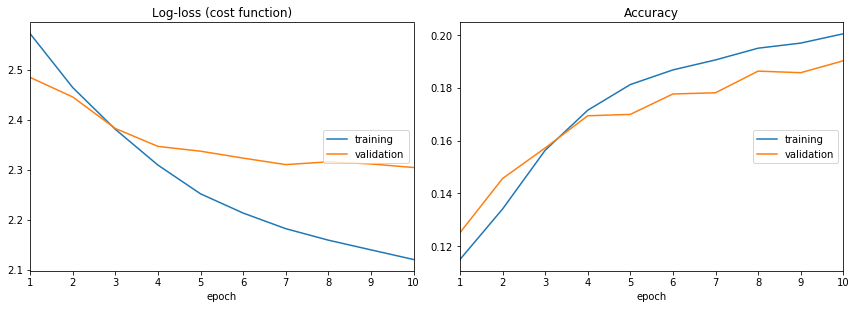

In [127]:
history = model.fit([train_x_fft],
                    train_y_chord_type,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_x_fft, val_y_chord_type),
                    callbacks=[PlotLossesKeras()])

In [128]:
model.evaluate(test_x_fft, test_y_chord_type)

  512/54476 [..............................] - ETA: 19s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


54476/54476 [==============================] - 27s 501us/step


[2.644049613501534, 0.14231955356541967]

Predicting the chord type (maj, min, dim, aug, etc.) appears to be a bit more difficult than the other categories. 

I wonder if this is due to more sparsity in these classes than in the others.  I suspect we may see gains here when we run with more data.

## Multi-output (predict all the predictors above in one neural net)

In [139]:
in_data = Input(shape=(8000, ))

lay1 = Dense(20, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
lay1 = Dropout(.4)(lay1)

lay2 = Dense(20, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
lay2 = Dropout(.4)(lay2)

# lay3 = Dense(50, activation='relu')(lay2)
# lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.4)(lay3)

output_chord_note_base = Dense(12, activation = "softmax")(lay2)
output_instrument_family = Dense(4, activation = "softmax")(lay2)
output_chord_type = Dense(13, activation = "softmax")(lay2)

model = Model(inputs=[in_data],
              outputs=[output_chord_note_base, output_instrument_family, output_chord_type])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

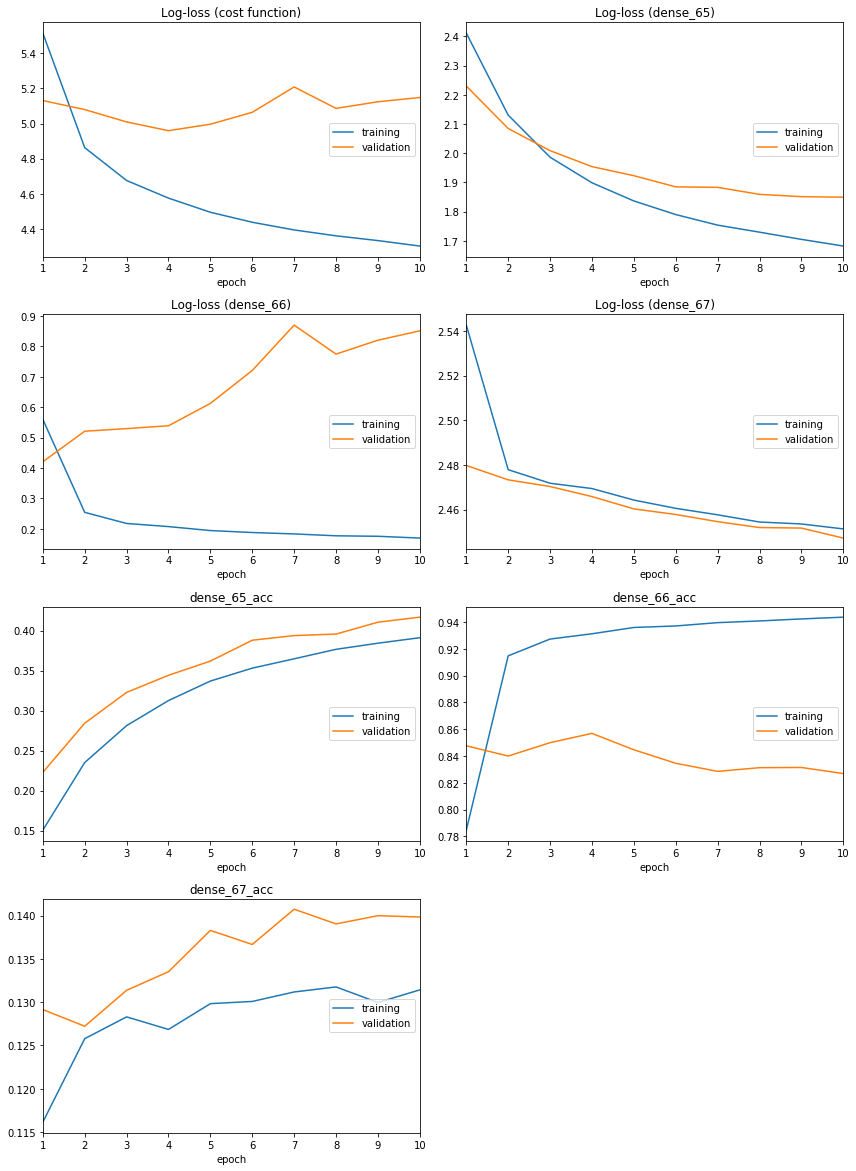

In [140]:
history = model.fit([train_x_fft],
                    [train_y_note_base, train_y_instrument_family, train_y_chord_type],
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_x_fft, [val_y_note_base, val_y_instrument_family, val_y_chord_type]),
                    callbacks=[PlotLossesKeras()])

In [141]:
model.evaluate(test_x_fft, [test_y_note_base, test_y_instrument_family, test_y_chord_type])

  608/54476 [..............................] - ETA: 15s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


54476/54476 [==============================] - 22s 410us/step


[8.222284226894063,
 2.6779054772075694,
 3.0614208979214137,
 2.4829578451476912,
 0.21987664292587197,
 0.4816800058763347,
 0.1241647698074345]

# TO DOs:

- Generate chords for more instruments and see if we can still get high accuracy when we increase that
- Potentially play with more instrument sources.  All these chords are from acoustic instrumentation, but we can generate data from "synthetic" as well as "electronic" instrumentation as well
- Run model with all data and see if we can push accuracy further
- Play around more with model architecture and see if that does anything.  I completely 100% arbitrarily selected the one I used. 

# Model with Chris' recordings

In [4]:
cd ../

/Users/mattgraziano/Google Drive/Documents/Learning/IU/Fall18/engr511/project/engr511


## Import data

In [ ]:
# recording_filenames = glob("data/recordings/*/*.wav", recursive=True)

In [97]:
recording_filenames = glob("data/recordings_new/*/*/*.wav", recursive=True)

In [98]:
from src.Progression_Modeling import Load, Prepare, Mel_transform, normalize, melspectrogram, trim, CQT_transform, pseudo_cqt
import soundfile as sf

In [99]:
A0 = 27.5
A1 = 55.00
C1 = 32.70
A2 = 110.00
C2 = 65.41
E6 = 1318.51
C7 = 2093.00
C8 = 4186.01

In [100]:
def nth_largest_col_sum(arr, n=-80):
    # column sum
    agg = np.sum(arr, axis=0)
    agg.sort()
    return agg[n]
    

In [101]:
def get_spectrogram(signal, sr=44100, spectype="mel"):
    if spectype == "mel":
        spectrogram = melspectrogram(Prepare(signal), sr=sr, fmin=C2, fmax=C7, n_fft=2048 * 2, hop_length=1024)
        spectrogram_norm = pow(normalize(spectrogram), .25)
    elif spectype == "cqt":
        A1 = 55.00
        spectrogram = abs(pseudo_cqt(Prepare(signal), sr, fmin=A1, n_bins=120, bins_per_octave=24, sparsity=.95, window=('kaiser', 10)))
        spectrogram_norm = normalize(spectrogram, norm='l1', axis=0)
    return spectrogram_norm

In [102]:
def get_clean_x(signal, sr=44100, nth_largest=-45, spectype="mel"):
    spectrogram = get_spectrogram(signal, sr=sr, spectype=spectype)

    # Get 45th largest value
    nth_largest_threshold = nth_largest_col_sum(spectrogram, nth_largest)

    # remove all columsn whose sum is less than t
    clean = spectrogram[:, np.sum(spectrogram, axis=0) >= nth_largest_threshold]
    
    return clean

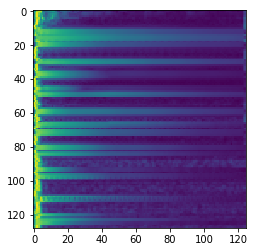

In [103]:
a = get_spectrogram(sf.read(recording_filenames[16])[0])
plt.imshow(a)

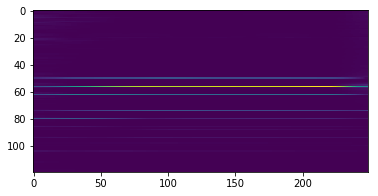

In [104]:
a_cqt = get_spectrogram(sf.read(recording_filenames[16])[0], spectype="cqt")
plt.imshow(a_cqt)

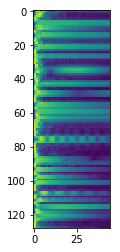

In [12]:
plt.imshow(get_clean_x(sf.read(recording_filenames[50])[0]))

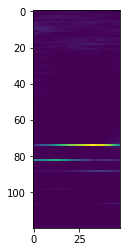

In [107]:
plt.imshow(get_clean_x(sf.read(recording_filenames[50])[0], spectype="cqt"))

In [108]:
raw_signals = []
samp_rates = []
x_train = []
for filename in tqdm(recording_filenames):
    sound, sr = sf.read(filename)
    
    raw_signals.append(sound)
    samp_rates.append(sr)
    cleaned = get_clean_x(sound, sr=sr, nth_largest=-1, spectype="cqt")
    cleaned = cleaned[:, 0]
    x_train.append(cleaned.flatten())
    

In [109]:
# Ensure that all x_train are the same size. 
x_train[14].shape

(120,)

In [110]:
x_train[1].shape

(120,)

In [111]:
x_train = np.vstack(x_train)

In [15]:
sound, sr = sf.read("../data/nsynth-train/generated_chords_single_foursec/A#1_dim7_guitar_acoustic_003_iter0.wav", -16)

In [16]:
test_sound, sr = sf.read("../data/nsynth-train/generated_chords_single_foursec/A#1_dim_keyboard_acoustic_013_iter0.wav")

In [17]:
test = get_clean_x(test_sound, sr=sr, nth_largest=-1)

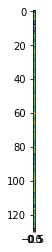

In [18]:
plt.imshow(test)

In [19]:
# Flatten spectrogram for input into neural net
x_train = np.array([i.flatten() for i in spectrogram_cleaned])

NameError: name 'spectrogram_cleaned' is not defined

In [115]:
# Get y categories
y_train = [i.split('/')[2] for i in recording_filenames]

le_chord_structure = LabelEncoder()
le_chord_structure.fit(y_train)
y_train_int = to_categorical(le_chord_structure.transform(y_train))


## Modeling:

In [139]:
in_data = Input(shape=(x_train.shape[1], ))

lay1 = Dense(20, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)

lay2 = Dense(20, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)

output = Dense(y_train_int.shape[1], activation = "softmax")(lay2)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

In [140]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_125 (InputLayer)       (None, 120)               0         
_________________________________________________________________
dense_373 (Dense)            (None, 20)                2420      
_________________________________________________________________
batch_normalization_249 (Bat (None, 20)                80        
_________________________________________________________________
dense_374 (Dense)            (None, 20)                420       
_________________________________________________________________
batch_normalization_250 (Bat (None, 20)                80        
_________________________________________________________________
dense_375 (Dense)            (None, 4)                 84        
Total params: 3,084
Trainable params: 3,004
Non-trainable params: 80
_________________________________________________________________


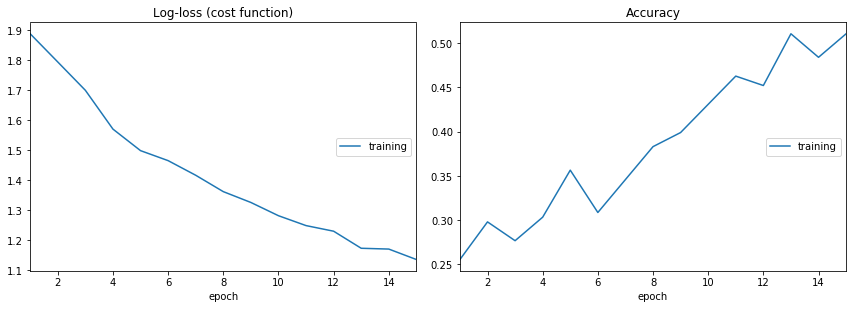

In [141]:
history = model.fit([x_train],
                    [y_train_int],
                    epochs=15,
                    batch_size=32,
                    callbacks=[PlotLossesKeras()])

In [142]:
model.evaluate(x=x_train, y=y_train_int)

188/188 [==============================] - 4s 23ms/step


[1.1124346230892426, 0.5265957427785751]

#### Leave one out cross validation

In [22]:
def mod(input_shape):
    
    in_data = Input(shape=(input_shape, ))

    lay1 = Dense(50, activation='relu')(in_data)
    lay1 = BatchNormalization()(lay1)

    lay2 = Dense(50, activation='relu')(lay1)
    lay2 = BatchNormalization()(lay2)

    output = Dense(y_train_int.shape[1], activation = "softmax")(lay2)

    model = Model(inputs=[in_data],
                  outputs=[output])

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics=['acc'])
    
    return model

In [23]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(x_train)

59

In [84]:
pred_track = []
classification_correct_track = []
for train_index, test_index in tqdm(loo.split(x_train), total=x_train.shape[0]):
    # Get train test split
    X_train_iter, X_test_iter = x_train[train_index], x_train[test_index]
    y_train_iter, y_test_iter = y_train_int[train_index], y_train_int[test_index]

    # Train model
    mod_iter = mod(x_train.shape[1])
    history = mod_iter.fit([x_train],
                           [y_train_int],
                            epochs=15,
                            batch_size=16,
                            verbose=1)
#                             callbacks=[PlotLossesKeras()])
    
    # Make test prediction
    pred = mod_iter.predict(X_test_iter)
    pred_track.append(pred)

    test_pred = np.argmax(pred)
    test_actual = np.argmax(y_test_iter)
    
    if test_pred == test_actual:
        classification_correct_track.append(1)
    else:
        classification_correct_track.append(0)
    
    

Epoch 1/15
59/59 [==============================] - 5s 84ms/step - loss: 2.0260 - acc: 0.2034
Epoch 2/15
59/59 [==============================] - 0s 291us/step - loss: 1.6412 - acc: 0.2712
Epoch 3/15
59/59 [==============================] - 0s 284us/step - loss: 1.3773 - acc: 0.3729
Epoch 4/15
59/59 [==============================] - 0s 366us/step - loss: 1.2292 - acc: 0.3898
Epoch 5/15
59/59 [==============================] - 0s 271us/step - loss: 1.0835 - acc: 0.5254
Epoch 6/15
59/59 [==============================] - 0s 316us/step - loss: 0.8941 - acc: 0.6271
Epoch 7/15
59/59 [==============================] - 0s 296us/step - loss: 0.8238 - acc: 0.6610
Epoch 8/15
59/59 [==============================] - 0s 309us/step - loss: 0.7813 - acc: 0.7627
Epoch 9/15
59/59 [==============================] - 0s 326us/step - loss: 0.7077 - acc: 0.8305
Epoch 10/15
59/59 [==============================] - 0s 310us/step - loss: 0.5913 - acc: 0.8644
Epoch 11/15
59/59 [==============================]

Epoch 12/15
59/59 [==============================] - 0s 314us/step - loss: 0.5606 - acc: 0.8305
Epoch 13/15
59/59 [==============================] - 0s 303us/step - loss: 0.5309 - acc: 0.9492
Epoch 14/15
59/59 [==============================] - 0s 293us/step - loss: 0.5572 - acc: 0.8475
Epoch 15/15
59/59 [==============================] - 0s 323us/step - loss: 0.4668 - acc: 0.9661
Epoch 1/15
59/59 [==============================] - 6s 96ms/step - loss: 2.0648 - acc: 0.2712
Epoch 2/15
59/59 [==============================] - 0s 318us/step - loss: 1.8331 - acc: 0.2712
Epoch 3/15
59/59 [==============================] - 0s 339us/step - loss: 1.4621 - acc: 0.3559
Epoch 4/15
59/59 [==============================] - 0s 346us/step - loss: 1.3595 - acc: 0.4746
Epoch 5/15
59/59 [==============================] - 0s 318us/step - loss: 1.1588 - acc: 0.5763
Epoch 6/15
59/59 [==============================] - 0s 351us/step - loss: 1.0022 - acc: 0.6780
Epoch 7/15
59/59 [=============================

Epoch 8/15
59/59 [==============================] - 0s 297us/step - loss: 0.7978 - acc: 0.7797
Epoch 9/15
59/59 [==============================] - 0s 315us/step - loss: 0.7276 - acc: 0.7966
Epoch 10/15
59/59 [==============================] - 0s 319us/step - loss: 0.6840 - acc: 0.8305
Epoch 11/15
59/59 [==============================] - 0s 305us/step - loss: 0.6845 - acc: 0.8305
Epoch 12/15
59/59 [==============================] - 0s 325us/step - loss: 0.5663 - acc: 0.9153
Epoch 13/15
59/59 [==============================] - 0s 327us/step - loss: 0.6097 - acc: 0.8644
Epoch 14/15
59/59 [==============================] - 0s 308us/step - loss: 0.5338 - acc: 0.8814
Epoch 15/15
59/59 [==============================] - 0s 316us/step - loss: 0.5320 - acc: 0.8983
Epoch 1/15
59/59 [==============================] - 6s 99ms/step - loss: 1.8533 - acc: 0.2373
Epoch 2/15
59/59 [==============================] - 0s 336us/step - loss: 1.5396 - acc: 0.3729
Epoch 3/15
59/59 [===========================

59/59 [==============================] - 0s 366us/step - loss: 1.4738 - acc: 0.4237
Epoch 4/15
59/59 [==============================] - 0s 375us/step - loss: 1.3499 - acc: 0.4068
Epoch 5/15
59/59 [==============================] - 0s 380us/step - loss: 1.1312 - acc: 0.4915
Epoch 6/15
59/59 [==============================] - 0s 337us/step - loss: 1.0772 - acc: 0.5424
Epoch 7/15
59/59 [==============================] - 0s 364us/step - loss: 0.9332 - acc: 0.6610
Epoch 8/15
59/59 [==============================] - 0s 399us/step - loss: 0.8949 - acc: 0.6949
Epoch 9/15
59/59 [==============================] - 0s 354us/step - loss: 0.7781 - acc: 0.7119
Epoch 10/15
59/59 [==============================] - 0s 394us/step - loss: 0.7251 - acc: 0.6949
Epoch 11/15
59/59 [==============================] - 0s 390us/step - loss: 0.6865 - acc: 0.7797
Epoch 12/15
59/59 [==============================] - 0s 383us/step - loss: 0.6890 - acc: 0.8475
Epoch 13/15
59/59 [==============================] - 0s 39

Epoch 14/15
59/59 [==============================] - 0s 444us/step - loss: 0.5690 - acc: 0.8475
Epoch 15/15
59/59 [==============================] - 0s 511us/step - loss: 0.5420 - acc: 0.8305
Epoch 1/15
59/59 [==============================] - 7s 118ms/step - loss: 1.9646 - acc: 0.2034
Epoch 2/15
59/59 [==============================] - 0s 481us/step - loss: 1.6696 - acc: 0.3051
Epoch 3/15
59/59 [==============================] - 0s 444us/step - loss: 1.4411 - acc: 0.3390
Epoch 4/15
59/59 [==============================] - 0s 426us/step - loss: 1.3149 - acc: 0.3559
Epoch 5/15
59/59 [==============================] - 0s 430us/step - loss: 1.0774 - acc: 0.5593
Epoch 6/15
59/59 [==============================] - 0s 500us/step - loss: 1.0005 - acc: 0.6271
Epoch 7/15
59/59 [==============================] - 0s 446us/step - loss: 0.9538 - acc: 0.6102
Epoch 8/15
59/59 [==============================] - 0s 411us/step - loss: 0.8993 - acc: 0.5932
Epoch 9/15
59/59 [==============================

59/59 [==============================] - 0s 513us/step - loss: 0.6799 - acc: 0.8305
Epoch 10/15
59/59 [==============================] - 0s 502us/step - loss: 0.6747 - acc: 0.8644
Epoch 11/15
59/59 [==============================] - 0s 520us/step - loss: 0.6019 - acc: 0.8475
Epoch 12/15
59/59 [==============================] - 0s 502us/step - loss: 0.5912 - acc: 0.8814
Epoch 13/15
59/59 [==============================] - 0s 476us/step - loss: 0.5071 - acc: 0.9492
Epoch 14/15
59/59 [==============================] - 0s 519us/step - loss: 0.5335 - acc: 0.8814
Epoch 15/15
59/59 [==============================] - 0s 495us/step - loss: 0.4289 - acc: 0.9831
Epoch 1/15
59/59 [==============================] - 8s 128ms/step - loss: 1.8915 - acc: 0.2034
Epoch 2/15
59/59 [==============================] - 0s 437us/step - loss: 1.5423 - acc: 0.2712
Epoch 3/15
59/59 [==============================] - 0s 492us/step - loss: 1.2682 - acc: 0.3390
Epoch 4/15
59/59 [==============================] - 0s 

Epoch 5/15
59/59 [==============================] - 0s 550us/step - loss: 1.0472 - acc: 0.5932
Epoch 6/15
59/59 [==============================] - 0s 503us/step - loss: 0.9729 - acc: 0.6102
Epoch 7/15
59/59 [==============================] - 0s 541us/step - loss: 0.9078 - acc: 0.6780
Epoch 8/15
59/59 [==============================] - 0s 529us/step - loss: 0.8139 - acc: 0.6949
Epoch 9/15
59/59 [==============================] - 0s 541us/step - loss: 0.7632 - acc: 0.7627
Epoch 10/15
59/59 [==============================] - 0s 530us/step - loss: 0.7068 - acc: 0.7288
Epoch 11/15
59/59 [==============================] - 0s 538us/step - loss: 0.6424 - acc: 0.8305
Epoch 12/15
59/59 [==============================] - 0s 560us/step - loss: 0.5661 - acc: 0.9322
Epoch 13/15
59/59 [==============================] - 0s 506us/step - loss: 0.5506 - acc: 0.8644
Epoch 14/15
59/59 [==============================] - 0s 516us/step - loss: 0.4554 - acc: 0.8814
Epoch 15/15
59/59 [==========================

59/59 [==============================] - 0s 431us/step - loss: 0.5092 - acc: 0.8983
Epoch 1/15
59/59 [==============================] - 8s 139ms/step - loss: 1.8608 - acc: 0.2203
Epoch 2/15
59/59 [==============================] - 0s 445us/step - loss: 1.4366 - acc: 0.4068
Epoch 3/15
59/59 [==============================] - 0s 512us/step - loss: 1.2946 - acc: 0.3898
Epoch 4/15
59/59 [==============================] - 0s 482us/step - loss: 1.1497 - acc: 0.4237
Epoch 5/15
59/59 [==============================] - 0s 478us/step - loss: 0.9930 - acc: 0.5424
Epoch 6/15
59/59 [==============================] - 0s 426us/step - loss: 0.9420 - acc: 0.5424
Epoch 7/15
59/59 [==============================] - 0s 484us/step - loss: 0.8498 - acc: 0.6780
Epoch 8/15
59/59 [==============================] - 0s 470us/step - loss: 0.7692 - acc: 0.7458
Epoch 9/15
59/59 [==============================] - 0s 457us/step - loss: 0.6624 - acc: 0.7288
Epoch 10/15
59/59 [==============================] - 0s 443us

59/59 [==============================] - 0s 509us/step - loss: 0.7103 - acc: 0.7797
Epoch 12/15
59/59 [==============================] - 0s 429us/step - loss: 0.6539 - acc: 0.8644
Epoch 13/15
59/59 [==============================] - 0s 432us/step - loss: 0.5571 - acc: 0.8644
Epoch 14/15
59/59 [==============================] - 0s 385us/step - loss: 0.6772 - acc: 0.7458
Epoch 15/15
59/59 [==============================] - 0s 548us/step - loss: 0.5719 - acc: 0.8644
Epoch 1/15
59/59 [==============================] - 9s 158ms/step - loss: 2.0606 - acc: 0.1695
Epoch 2/15
59/59 [==============================] - 0s 500us/step - loss: 1.7743 - acc: 0.2034
Epoch 3/15
59/59 [==============================] - 0s 452us/step - loss: 1.5491 - acc: 0.3559
Epoch 4/15
59/59 [==============================] - 0s 393us/step - loss: 1.3691 - acc: 0.3729
Epoch 5/15
59/59 [==============================] - 0s 406us/step - loss: 1.2646 - acc: 0.4915
Epoch 6/15
59/59 [==============================] - 0s 44

Epoch 7/15
59/59 [==============================] - 0s 430us/step - loss: 0.8850 - acc: 0.7119
Epoch 8/15
59/59 [==============================] - 0s 412us/step - loss: 0.9253 - acc: 0.6441
Epoch 9/15
59/59 [==============================] - 0s 418us/step - loss: 0.7538 - acc: 0.7458
Epoch 10/15
59/59 [==============================] - 0s 412us/step - loss: 0.7850 - acc: 0.6780
Epoch 11/15
59/59 [==============================] - 0s 416us/step - loss: 0.7037 - acc: 0.7966
Epoch 12/15
59/59 [==============================] - 0s 479us/step - loss: 0.6977 - acc: 0.7797
Epoch 13/15
59/59 [==============================] - 0s 492us/step - loss: 0.6314 - acc: 0.8475
Epoch 14/15
59/59 [==============================] - 0s 509us/step - loss: 0.5815 - acc: 0.8644
Epoch 15/15
59/59 [==============================] - 0s 577us/step - loss: 0.5439 - acc: 0.8475
Epoch 1/15
59/59 [==============================] - 9s 160ms/step - loss: 2.0586 - acc: 0.2542
Epoch 2/15
59/59 [==========================

59/59 [==============================] - 0s 461us/step - loss: 1.5717 - acc: 0.2881
Epoch 3/15
59/59 [==============================] - 0s 484us/step - loss: 1.3918 - acc: 0.3729
Epoch 4/15
59/59 [==============================] - 0s 488us/step - loss: 1.2773 - acc: 0.4068
Epoch 5/15
59/59 [==============================] - 0s 460us/step - loss: 1.1364 - acc: 0.5763
Epoch 6/15
59/59 [==============================] - 0s 465us/step - loss: 1.0179 - acc: 0.5424
Epoch 7/15
59/59 [==============================] - 0s 473us/step - loss: 1.0085 - acc: 0.6102
Epoch 8/15
59/59 [==============================] - 0s 476us/step - loss: 0.7987 - acc: 0.7797
Epoch 9/15
59/59 [==============================] - 0s 448us/step - loss: 0.7751 - acc: 0.7797
Epoch 10/15
59/59 [==============================] - 0s 470us/step - loss: 0.6922 - acc: 0.8136
Epoch 11/15
59/59 [==============================] - 0s 481us/step - loss: 0.7188 - acc: 0.7966
Epoch 12/15
59/59 [==============================] - 0s 485

In [85]:
np.sum(classification_correct_track)

57

In [87]:
57/59

0.9661016949152542

#### K-fold cross val

In [149]:
n_folds=10

In [150]:
from sklearn.model_selection import KFold
kfold = KFold(n_folds)
kfold.get_n_splits(x_train)

10

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [208]:
pred_track_nn = []
classification_correct_track_nn = []

pred_track_rf = []
classification_correct_track_rf = []

pred_track_lr = []
classification_correct_track_lr = []

actuals = []

for train_index, test_index in tqdm(kfold.split(x_train), total=n_folds):
    # Get train test split
    X_train_iter, X_test_iter = x_train[train_index], x_train[test_index]
    y_train_iter, y_test_iter = y_train_int[train_index], y_train_int[test_index]

    # Train neural net model
    print("Neural net")
    mod_iter = mod(x_train.shape[1])
    history = mod_iter.fit([x_train],
                           [y_train_int],
                            epochs=15,
                            batch_size=16,
                            verbose=0)
#                             callbacks=[PlotLossesKeras()])
    
    # Train Random Forest
    print("RF")
    rf = RandomForestClassifier(n_estimators=500,
                                n_jobs=8,
                                min_samples_leaf=5)
    rf.fit(X_train_iter, y_train_iter)
    
    
    # Train Log Reg
    print("Log Reg")
    lr = LogisticRegression()
    lr.fit(X_train_iter, np.argmax(y_train_iter, axis=1))
    
    
    # Make test prediction
    
    #NN
    pred = mod_iter.predict(X_test_iter)
    pred_track_nn.append(pred)
    test_pred = np.argmax(pred, axis=1)
    test_actual = np.argmax(y_test_iter, axis=1)
    classification_correct_track_nn.append(np.sum(test_pred == test_actual))

    
    #RF
    pred = rf.predict(X_test_iter)
    pred_track_rf.append(pred)
    test_pred = pred
    test_actual = np.argmax(y_test_iter, axis=1)
    classification_correct_track_rf.append(np.sum(test_pred == test_actual))

    
    #LR
    pred = lr.predict(X_test_iter)
    pred_track_lr.append(pred)
    test_pred = pred
    test_actual = np.argmax(y_test_iter, axis=1)
    classification_correct_track_lr.append(np.sum(test_pred == test_actual))

    actuals.append(y_test_iter)
    
    

Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Neural net
RF
Log Reg


/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [209]:
# Get total Accuracy:
np.sum(classification_correct_track_nn) / x_train.shape[0]

0.8457446808510638

In [210]:
np.sum(classification_correct_track_rf) / x_train.shape[0]

0.0

In [211]:
np.sum(classification_correct_track_lr) / x_train.shape[0]

0.015957446808510637

The Random Forest and Logistic regression models did not perform well. 

This may suggest there is significant non-linearly in the data theses models are not capturing.

